# Deep Optimal Stopping and Dual Pricing of Bermudan Options

### Auteurs :
- **Philippe Yao**
- **Georges Rolland**

### Encadrants :
- **Vincent Lemaire**
- **Gilles Pagès**

### Formation :
Master 2 Probabilités et Finance, année universitaire 2024–2025

---

### Présentation du projet :

Ce projet porte sur la valorisation d’options Bermudéennes, un type d’option exerçable à dates discrètes, via des méthodes issues de l’apprentissage profond et de la théorie des martingales.

L’approche s’inspire de deux articles clés :
- **Becker, Cheridito, Jentzen (2019)** — *Deep Optimal Stopping*, qui propose une méthode d'entraînement de réseaux de neurones pour approximer la politique d’exercice optimale et construire une borne inférieure du prix.
- **Rogers (2002)** — *Monte Carlo valuation of American options using a martingale representation*, qui introduit une formulation duale pour encadrer la valeur de l’option à l’aide de martingales surmajorantes.

Nous implémentons ces deux stratégies pour construire des bornes inférieure et supérieure encadrant le prix de l’option. L’implémentation est enrichie par des techniques de réduction de variance (notamment la méthode de variable de contrôle), et l’ensemble est évalué par des simulations dans un cadre de Black-Scholes multidimensionnel.


### Librairies

In [ ]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist

# Plotting style
sns.set_theme()

# Select device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Parameters

In [ ]:
# Parameters
r = 0.05              # Risk-free rate
sigma = 0.2           # Volatility
dividend = 0.1        # Dividend Yield
x0 = 100              # Initial asset price
K = 100               # Strike price
rho = 0.0               # Assets correlation (Brownians correlation)
T = 3                 # Maturity (in years)
N=9                # Number of exercise dates
d = 5
n_assets = 5                  # Asset numbers
M = 8192
dt = T / N            # Time step
delta = 0.1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Matrice de corrélation
rho_matrix = torch.eye(n_assets, device=device) * (1 - rho) + torch.ones((n_assets, n_assets), device=device) * rho

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


### Paths simulations

### Simulation des trajectoires Black-Scholes

Génère des trajectoires log-normales de $d$ actifs selon le modèle de Black-Scholes discrétisé, avec drift et diffusion constants.



In [ ]:
def simulate_black_scholes_paths(x0, r, sigma, delta, T, N, M, d=5, device="cpu"):
    dt = T / N
    Z = torch.randn(N, M, d, device=device)

    x0 = torch.full((M, d), x0, device=device) if not torch.is_tensor(x0) else x0
    sigma = torch.full((d,), sigma, device=device) if not torch.is_tensor(sigma) else sigma
    delta = torch.full((d,), delta, device=device) if not torch.is_tensor(delta) else delta

    drift = (r - delta - 0.5 * sigma**2) * dt
    diffusion = sigma * torch.sqrt(torch.tensor(dt, device=device))

    increments = drift.unsqueeze(0).unsqueeze(0) + diffusion.unsqueeze(0).unsqueeze(0) * Z
    log_paths = torch.log(x0) + torch.cumsum(increments, dim=0)

    paths = torch.cat([
        x0.unsqueeze(0),
        torch.exp(log_paths)
    ], dim=0)

    return paths  # (N+1, M, d)


### Payoff de l'option max-call Bermudéenne

Cette fonction calcule le payoff d’une option Bermudéenne de type max-call à une date donnée, selon la formule :

$$
\text{Payoff}(S) = \left( \max_{1 \leq i \leq d} S_i - K \right)^+
$$


In [ ]:
def bermudan_max_call_payoff(S, K):
    """
    Calcule le payoff d'une option Bermudéenne Max-Call.

    S : tensor (M, d) — Prix des actifs à la date d'exercice (M trajectoires, d actifs)
    K : float — Strike de l'option

    Retourne :
    payoff : tensor (M,) — Payoff pour chaque trajectoire
    """

    # Prend le maximum des actifs pour chaque trajectoire (sur la dimension des actifs)
    max_S = torch.max(S, dim=1).values  # shape (M,)

    # Payoff = (max_S - K)+
    payoff = torch.clamp(max_S - K, min=0.0)  # shape (M,)

    return payoff


In [ ]:
def compute_all_payoffs(S_paths, K):
    """
    Calcule les payoffs à chaque pas de temps.
    S_paths : (N+1, M, d)
    Retourne : tensor (N+1, M)
    """
    N_plus_1, M, d = S_paths.shape
    payoffs = torch.zeros(N_plus_1, M, device=S_paths.device)

    for n in range(N_plus_1):
        payoffs[n] = bermudan_max_call_payoff(S_paths[n], K)

    return payoffs


### Network architecture

In [ ]:
# Fonction utilitaire : normalisation d'un batch
def normalize_batch(batch):
    """
    Normalise un batch de données (par feature)
    batch : tensor (batch_size, d)
    """
    mean = batch.mean(dim=0, keepdim=True)
    std = batch.std(dim=0, keepdim=True) + 1e-8  # pour éviter la division par 0
    return (batch - mean) / std

### Réseau de neurones pour l'arrêt optimal

Le réseau `StoppingNet` approxime la probabilité d'arrêt à chaque date. Il prend en entrée l’état du système $ S_n \in \mathbb{R}^d $ et renvoie une probabilité $ p_n \in (0,1) $. Il est composé de 3 couches cachées et utilise une activation sigmoïde en sortie :

$$
f_\theta(S_n) \approx \mathbb{P}(\text{arrêt à } t_n \mid S_n)
$$


In [ ]:
# Réseau de neurones avec 3 couches cachées
class StoppingNet(nn.Module):
    def __init__(self, d, hidden_size=None):
        """
        d : dimension d'entrée (dimension de l'état)
        hidden_size : taille des couches cachées (par défaut 40 + d)
        """
        super(StoppingNet, self).__init__()
        if hidden_size is None:
            hidden_size = 40 + d

        # Réseau plus profond avec 3 couches cachées
        self.fc1 = nn.Linear(d, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)

        # Initialisation Xavier
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Sortie entre (0,1)
        return x.squeeze(-1)  # Retourne (batch_size,)


### Entraînement des réseaux de neurones pour l’arrêt optimal

Cette fonction entraîne une suite de réseaux $\{f_n^\theta\}_{n=0}^{N-1}$ pour approximer les décisions d'arrêt à chaque date $t_n$. L'apprentissage se fait en backward induction : on commence par $n = N-1$ et on remonte jusqu'à $n = 1$, en fixant $f_N \equiv 1$ (arrêt obligatoire à maturité).

L'objectif à chaque étape $n$ est de maximiser l'espérance :
$$
\mathbb{E}\left[f_n^\theta(X_n) \cdot g(n, X_n) + (1 - f_n^\theta(X_n)) \cdot g(\tau_{n+1}, X_{\tau_{n+1}})\right],
$$
où $g(n, x)$ est le payoff à l'instant $n$ et $\tau_{n+1}$ le temps d'arrêt futur défini par les réseaux déjà entraînés aux dates ultérieures.

Le terme $f_n^\theta(X_n)$ représente la probabilité (souple) d'arrêt donnée par le réseau. Une descente de gradient stochastique (Adam) est utilisée pour optimiser ce critère sur des mini-batchs. Après chaque entraînement, les temps d’arrêt $\tau^\theta$ sont mis à jour en appliquant une règle dure : on arrête dès que $f_n^\theta(X_n) > 0.5$.

Cette stratégie récursive permet d'approximer un temps d'arrêt optimal sur des trajectoires simulées, constituant la base de l'estimateur $\hat{L}$ pour la borne inférieure.


In [ ]:
def train_stopping_networks(S_paths, payoffs, N, batch_size=8192, lr=1e-3, n_epochs=1, verbose=True):
    """
    Entraîne les réseaux de neurones pour l'optimal stopping.

    S_paths : tensor (N+1, M, d) — trajectoires simulées
    payoffs : tensor (N+1, M) — payoffs simulés à chaque pas de temps
    N : nombre total de pas de temps
    batch_size : taille des mini-batchs
    lr : learning rate
    n_epochs : nombre d'époques d'apprentissage pour chaque réseau
    verbose : bool — si True, affiche la loss pendant l'entraînement

    Retourne :
    list_models : liste des modèles (de n=N-1 à n=1)
    loss_history : liste des pertes pour chaque réseau
    """
    M, d = S_paths.shape[1], S_paths.shape[2]
    device = S_paths.device

    # Initialisation des réseaux
    models = [StoppingNet(d).to(device) for _ in range(N)]

    # Stocke l'historique des pertes
    loss_history = [[] for _ in range(N)]

    # Initialisation des temps d'arrêt connus : à N, on s'arrête toujours
    stopping_decision = torch.ones(M, device=device)

    for n in reversed(range(1, N)):
        model = models[n-1]
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if verbose:
            print(f"Training model for time step {n}...")

        for epoch in range(n_epochs):
            perm = torch.randperm(M)
            batch_losses = []
            for i in range(0, M, batch_size):
                idx = perm[i:i+batch_size]
                S_batch = S_paths[n, idx]
                S_batch = normalize_batch(S_batch)

                payoff_now = payoffs[n, idx]
                payoff_future = payoffs[stopping_decision[idx].long(), idx]

                # Forward pass
                stop_prob = model(S_batch)

                # Calcul de la loss
                loss = -torch.mean(
                    stop_prob * payoff_now + (1 - stop_prob) * payoff_future
                )

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Stocke la perte pour ce batch
                batch_losses.append(loss.item())

                if verbose:
                    print(f"Time step {n}, Epoch {epoch+1}, Batch {i//batch_size+1}, Loss: {loss.item():.6f}")

            # Enregistre la perte moyenne sur cette époque
            loss_history[n-1].append(sum(batch_losses) / len(batch_losses))

          # Mise à jour des décisions d'arrêt après entraînement
        with torch.no_grad():
            S_batch_full = normalize_batch(S_paths[n])
            stop_prob_full = model(S_batch_full)
            new_stop = stop_prob_full > 0.5  # décision dure
            # On met à jour les temps d'arrêt
            stopping_decision = torch.where(new_stop, torch.full_like(stopping_decision, n), stopping_decision)

    return models, loss_history


In [ ]:
# Fonction utilitaire : lissage avec moyenne glissante
def moving_average(values, window=5):
    """
    Calcule la moyenne glissante d'une liste de valeurs.
    values : list of floats
    window : taille de la fenêtre
    """
    if len(values) < window:
        return values  # pas assez de points pour lisser
    return [sum(values[i-window:i])/window for i in range(window, len(values)+1)]


### Estimation de la borne inférieure $\hat{L}$

Ce bloc applique la politique d’arrêt optimale apprise pour estimer la borne inférieure du prix de l’option Bermudéenne. Pour chaque trajectoire simulée, on utilise les réseaux de neurones $\{f_n^\theta\}$ pour déterminer le premier temps $n$ tel que $f_n^\theta(X_n) > 0.5$, ce qui correspond à l’exercice anticipé de l’option.

On calcule ensuite le payoff associé à ce temps d’arrêt $\tau^\theta$, puis on actualise ce gain à la date initiale via le facteur $\exp(-r (T - t_{\tau^\theta}))$. L’estimateur final est :
$$
\hat{L} = \frac{1}{M} \sum_{i=1}^M e^{-r(T - t_{\tau_i})} \cdot \left( \max_{j=1,\dots,d} S_j^{(i)}(t_{\tau_i}) - K \right)^+,
$$
où $M$ est le nombre de trajectoires simulées et $\tau_i$ le temps d’arrêt sur la $i$-ème trajectoire.

On retourne à la fois la moyenne des gains actualisés et leur variance empirique.


In [ ]:
def estimate_lower_bound(models, S_paths, K):
    """
    Estime la borne inférieure du prix de l'option par Monte Carlo (avec actualisation).

    Inputs :
    - models : liste des réseaux (un par temps d’arrêt t_n)
    - S_paths : trajectoires simulées, shape (N+1, M, d)
    - K : strike
    - r : taux sans risque
    - T : maturité

    Returns :
    - lower_bound : estimation moyenne actualisée
    - variance : variance empirique des payoffs actualisés
    """
    N_plus_1, M, d = S_paths.shape
    N = N_plus_1 - 1
    device = S_paths.device

    dt = T / N
    times = torch.arange(N_plus_1, device=device) * dt

    # Initialisation : arrêt forcé à T par défaut
    stopping_times = torch.full((M,), N, dtype=torch.long, device=device)

    for n in range(1, N):
        model = models[n-1]
        S_batch = normalize_batch(S_paths[n])
        stop_prob = model(S_batch)
        decision = stop_prob > 0.5

        stopping_times = torch.where(
            (stopping_times == N) & decision,
            torch.full_like(stopping_times, n),
            stopping_times
        )

    # Indices de temps arrêt + valeurs à l’arrêt
    discount_factors = torch.exp(-r * (T-times[stopping_times]))  # shape (M,)
    payoffs_raw = bermudan_max_call_payoff(S_paths[stopping_times, torch.arange(M)], K)

    discounted_payoffs = discount_factors * payoffs_raw

    lower_bound = discounted_payoffs.mean().item()
    variance = discounted_payoffs.var(unbiased=True).item()

    return lower_bound, variance


Training model for time step 8...
Time step 8, Epoch 1, Batch 1, Loss: -19.669641
Time step 8, Epoch 2, Batch 1, Loss: -19.924610
Time step 8, Epoch 3, Batch 1, Loss: -20.176554
Time step 8, Epoch 4, Batch 1, Loss: -20.425640
Time step 8, Epoch 5, Batch 1, Loss: -20.671724
Time step 8, Epoch 6, Batch 1, Loss: -20.914625
Time step 8, Epoch 7, Batch 1, Loss: -21.154478
Time step 8, Epoch 8, Batch 1, Loss: -21.391460
Time step 8, Epoch 9, Batch 1, Loss: -21.625961
Time step 8, Epoch 10, Batch 1, Loss: -21.858231
Time step 8, Epoch 11, Batch 1, Loss: -22.088814
Time step 8, Epoch 12, Batch 1, Loss: -22.317373
Time step 8, Epoch 13, Batch 1, Loss: -22.543558
Time step 8, Epoch 14, Batch 1, Loss: -22.766945
Time step 8, Epoch 15, Batch 1, Loss: -22.987343
Time step 8, Epoch 16, Batch 1, Loss: -23.204193
Time step 8, Epoch 17, Batch 1, Loss: -23.416840
Time step 8, Epoch 18, Batch 1, Loss: -23.624720
Time step 8, Epoch 19, Batch 1, Loss: -23.826866
Time step 8, Epoch 20, Batch 1, Loss: -24.02

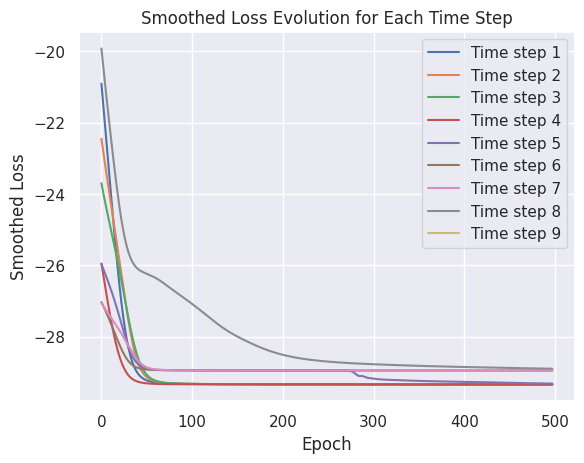

In [ ]:
# Simuler
S_paths = simulate_black_scholes_paths(x0, r, sigma, dividend, T, N=N, M=M, d=d, device=device)

# Calculer les payoffs
payoffs = compute_all_payoffs(S_paths, K)

# Entraîner
models, loss_history = train_stopping_networks(S_paths, payoffs, N=9, batch_size=8192, lr=1e-3, n_epochs=500)

for n, losses in enumerate(loss_history):
    smoothed_losses = moving_average(losses, window=3)
    plt.plot(smoothed_losses, label=f'Time step {n+1}')

plt.xlabel('Epoch')
plt.ylabel('Smoothed Loss')
plt.title('Smoothed Loss Evolution for Each Time Step')
plt.legend()
plt.show()




### Construction des martingales candidates pour le calcul de la borne supérieure

### Exchange option martingale (discounted)

### Construction de la martingale candidate $M^{(1)}$ : option d'échange

Cette fonction construit une martingale basée sur la valeur actualisée d'une option européenne d’échange entre les deux actifs les plus performants à chaque date $t$. Elle repose sur la formule de Margrabe, activée uniquement lorsque $\max_i S_i(t) > K$. La martingale résultante est utilisée comme composante dans l’estimateur dual de Rogers.

$$
\text{Ex}(t) = S^{(1)}_t e^{-\delta (T - t)} \Phi(d_1) - S^{(2)}_t e^{-\delta (T - t)} \Phi(d_2),
\quad
d_1 = \frac{\log\left(S^{(1)}_t / S^{(2)}_t\right) + \frac{1}{2} \sigma^2 (T - t)}{\sigma \sqrt{2(T - t)}}
$$


In [ ]:
def build_exchange_option_martingale(S_paths, K, r, delta, sigma, T):
    """
    Construit correctement la martingale de l'option d'échange :
    - Prix européen actualisé à chaque date,
    - Incréments cumulés uniquement lorsque S_max > K à CHAQUE date,
    - Pas de désactivation définitive.
    """

    N_plus_1, M, d = S_paths.shape
    times = torch.linspace(0, T, N_plus_1, device=S_paths.device)
    discount_factors = torch.exp(-r * (times))

    normal = dist.Normal(0., 1.)

    # --- Construction du processus brut M_t ---
    M_brut = torch.zeros(N_plus_1, M, device=S_paths.device)

    for t in range(N_plus_1):
        S = S_paths[t]
        sorted_S, _ = torch.sort(S, dim=-1, descending=True)
        S_max = sorted_S[:, 0]
        S_second = sorted_S[:, 1]

        tau = T - times[t]

        if tau > 0:
            vol_sqrt_tau = sigma * math.sqrt(2) * torch.sqrt(torch.tensor(tau, device=S.device))
            d1 = (torch.log(S_max / S_second) + sigma**2 * tau) / vol_sqrt_tau
            d2 = d1 - vol_sqrt_tau

            european_exchange = torch.exp(-delta * tau) * (S_max * normal.cdf(d1) - S_second * normal.cdf(d2))
        else:
            european_exchange = torch.clamp(S_max - S_second, min=0.0)

        M_brut[t] = discount_factors[t] * european_exchange

    # --- Calcul des incréments bruts ---
    increments = M_brut[1:] - M_brut[:-1]  # (N, M)

    # --- Correction dynamique sur les incréments ---
    corrected_increments = torch.zeros_like(increments)

    for t in range(N_plus_1 - 1):
        S = S_paths[t]
        sorted_S, _ = torch.sort(S, dim=-1, descending=True)
        S_max = sorted_S[:, 0]

        # Test dynamique : si S_max > K à l'instant t
        active_now = (S_max >= K).float()

        corrected_increments[t] = increments[t] * active_now

    # --- Reconstruction finale de la martingale ---
    martingale = torch.zeros(N_plus_1, M, device=S_paths.device)
    for t in range(1, N_plus_1):
        martingale[t] = martingale[t-1] + corrected_increments[t-1]

    return martingale


### Leading asset european call (discounted)

### Construction de la martingale $M^{(2)}$ : call européen sur l’actif leader

Cette fonction construit une martingale à partir du prix actualisé d’un call européen sur l’actif ayant le plus haut prix à chaque date $t$. La formule utilisée est celle de Black–Scholes avec dividende, et les incréments sont conservés uniquement lorsque $S_{\text{lead}} > K$ :


In [ ]:

def build_leading_asset_call_martingale(S_paths, K, r, delta, sigma, T):
    """
    Construit correctement la martingale du call européen sur l'actif leader :
    - Calcul du prix européen actualisé à chaque date,
    - Incréments cumulés uniquement lorsque S_lead > K à CHAQUE date,
    - Pas d'activation définitive.
    """

    N_plus_1, M, d = S_paths.shape
    times = torch.linspace(0, T, N_plus_1, device=S_paths.device)
    discount_factors = torch.exp(-r * (times))

    normal = dist.Normal(0., 1.)

    # --- Construction du processus brut M_t ---
    M_brut = torch.zeros(N_plus_1, M, device=S_paths.device)

    for t in range(N_plus_1):
        S = S_paths[t]
        # leader_idx = torch.argmax(S, dim=-1)
        # S_lead = S.gather(1, leader_idx.unsqueeze(-1)).squeeze(-1)
        sorted_S, _ = torch.sort(S, dim=-1, descending=True)
        S_lead = sorted_S[:, 0]

        tau = T - times[t]

        if tau > 0:
            vol_sqrt_tau = sigma * torch.sqrt(torch.tensor(tau, device=S.device))
            d1 = (torch.log(S_lead / K) + (r - delta + 0.5 * sigma**2) * tau) / vol_sqrt_tau
            d2 = d1 - vol_sqrt_tau

            european_call = S_lead * torch.exp(-delta * tau) * normal.cdf(d1) \
                            - K * torch.exp(-r * tau) * normal.cdf(d2)
        else:
            european_call = torch.clamp(S_lead - K, min=0.0)

        M_brut[t] = discount_factors[t] * european_call

    # --- Calcul des incréments bruts ---
    increments = M_brut[1:] - M_brut[:-1]  # (N, M)

    # --- Correction dynamique sur les incréments ---
    corrected_increments = torch.zeros_like(increments)

    for t in range(N_plus_1 - 1):
        S = S_paths[t]
        # leader_idx = torch.argmax(S, dim=-1)
        # S_lead = S.gather(1, leader_idx.unsqueeze(-1)).squeeze(-1)
        sorted_S, _ = torch.sort(S, dim=-1, descending=True)
        S_lead = sorted_S[:, 0]

        # Test dynamique : si S_lead > K à l'instant t
        active_now = (S_lead > K).float()

        corrected_increments[t] = increments[t] * active_now

    # --- Reconstruction finale de la martingale ---
    martingale = torch.zeros(N_plus_1, M, device=S_paths.device)
    for t in range(1, N_plus_1):
        martingale[t] = martingale[t-1] + corrected_increments[t-1]

    return martingale


### Optimisation des coefficients $\lambda$

Cette fonction ajuste les coefficients de combinaison linéaire des deux martingales candidates $(M^{(1)}, M^{(2)})$ afin de minimiser l'espérance de l'expression duale de la borne supérieure :
$$
\hat{U}(\lambda) = \mathbb{E}\left[ \max_{0 \leq n \leq N} \left( g(n, X_n) - M_n^\lambda \right) \right],
$$
où $M^\lambda = \lambda_1 M^{(1)} + \lambda_2 M^{(2)}$ .

L’optimisation est réalisée par descente de gradient avec l’algorithme L-BFGS.


In [ ]:

def optimize_lambda(martingale1, martingale2, payoffs, n_iter=500):
    """
    Optimise deux coefficients lambda1 = alpha et lambda2 = 1 - alpha,
    avec alpha restreint dans [-0.5, 0] via clamp après optimisation.

    Inputs :
    - martingale1, martingale2 : tensors (N+1, M)
    - payoffs : tensor (N+1, M), non actualisé
    - r : float, taux d’intérêt sans risque
    - T : float, maturité
    - n_iter : int, nombre d’itérations pour L-BFGS

    Output :
    - lambdas_star : tensor(2,) — coefficients optimisés
    """
    device = payoffs.device
    N_plus_1 = payoffs.size(0)

    # Discounting
    times = torch.linspace(0, T, N_plus_1, device=device)
    discount_factors = torch.exp(-r * (T - times)).unsqueeze(1)  # (N+1, 1)
    discounted_payoffs = discount_factors * payoffs  # (N+1, M)

    # Martingales combinées
    martingales_tensor = torch.stack([martingale1, martingale2], dim=-1)  # (N+1, M, 2)

    # Paramètre libre alpha ∈ ℝ
    alpha = torch.full((1,), 0.5, requires_grad=True, device=device)

    optimizer = torch.optim.LBFGS([alpha], max_iter=n_iter)

    def closure():
        optimizer.zero_grad()
        lambdas = torch.cat([alpha, 1 - alpha], dim=0)  # (2,)
        combined = (martingales_tensor @ lambdas).squeeze(-1)  # (N+1, M)
        gap = discounted_payoffs - combined
        sup_gap, _ = torch.max(gap, dim=0)
        loss = sup_gap.mean()
        loss.backward()
        return loss

    optimizer.step(closure)


    alpha_star = alpha.detach().clamp(-1.0, 0.0)
    lambdas_star = torch.cat([alpha_star, 1 - alpha_star], dim=0)

    return lambdas_star


### Upper bound

### Estimation de la borne supérieure $\hat{U}$

Cette fonction calcule la borne supérieure $\hat{U}$ par la méthode duale de Rogers. Elle utilise une combinaison linéaire de deux martingales candidates $M^{(1)}$ et $M^{(2)}$ :
$$
M^\lambda = \lambda_1 M^{(1)} + \lambda_2 M^{(2)},
$$
 L’estimateur est obtenu par :
$$
\hat{U} = \mathbb{E}\left[\max_{0 \leq n \leq N} \left( g(n, S_n) - M_n^\lambda \right)\right].
$$
La variance empirique est également renvoyée.


In [ ]:
def estimate_upper_bound(S_paths, K, r, delta, sigma, T, lambdas_star):
    """
    Estime la borne supérieure de l'option bermudéenne max-call et sa variance empirique.

    Inputs :
    - S_paths : tensor (N+1, M, d) chemins simulés
    - K, r, delta, sigma, T : paramètres financiers
    - lambdas_star : tensor (2,), coefficients constants optimisés

    Outputs :
    - upper_bound : float, estimateur de la borne supérieure
    - variance : float, variance empirique non biaisée
    """

    martingale_leading_call = build_leading_asset_call_martingale(S_paths, K, r, delta, sigma, T)
    martingale_exchange_option = build_exchange_option_martingale(S_paths, K, r, delta, sigma, T)
    payoffs = compute_all_payoffs(S_paths, K)

    combined_martingale = (
        lambdas_star[0] * martingale_leading_call +
        lambdas_star[1] * martingale_exchange_option
    )

    gap = payoffs - combined_martingale
    sup_gap, _ = torch.max(gap, dim=0)

    upper_bound = sup_gap.mean().item()
    variance = sup_gap.var(unbiased=True).item()

    return upper_bound, variance


In [ ]:
# --- Optimisation des coefficients λ sur des trajectoires indépendantes ---

N_train=40
M_train=1000
N_test = N
M_test = 8000

# 1. Simulation pour optimiser les lambdas (trajectoires fines, N=40)
S_paths_dual = simulate_black_scholes_paths(
    x0=x0, r=r, sigma=sigma, delta=delta, T=T,
    N=N_train, M=M_train, d=n_assets, device=device
)

# 2. Construction des martingales candidates
payoffs_dual = compute_all_payoffs(S_paths_dual, K)
martingale_leading = build_leading_asset_call_martingale(S_paths_dual, K, r, delta, sigma, T)
martingale_exchange = build_exchange_option_martingale(S_paths_dual, K, r, delta, sigma, T)

# 3. Optimisation des coefficients lambdas
lambdas_star = optimize_lambda(
    martingale1=martingale_leading,
    martingale2=martingale_exchange,
    payoffs=payoffs_dual,
    n_iter=200
)

# 4. Simulation pour évaluation finale de la borne supérieure (trajectoires grossières, N=9)
S_paths_test = simulate_black_scholes_paths(
    x0=x0, r=r, sigma=sigma, delta=delta, T=T,
    N=N_test, M=M_test, d=n_assets, device=device
)

print(f"Lambdas optimisés : {lambdas_star.cpu().numpy()}")


Lambdas optimisés : [0. 1.]


<ipython-input-52-698f6ce944d9>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_sqrt_tau = sigma * torch.sqrt(torch.tensor(tau, device=S.device))
<ipython-input-51-e8feb786f09d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_sqrt_tau = sigma * math.sqrt(2) * torch.sqrt(torch.tensor(tau, device=S.device))


### Intervalle de confiance

### Construction d’un intervalle de confiance

Cette fonction construit un intervalle de confiance asymétrique autour de la valeur réelle de l’option, basé sur les estimateurs $\hat{L}$ et $\hat{U}$. On utilise :
$$
\left[ \hat{L} - z_{\alpha/2} \frac{\hat{\sigma}_L}{\sqrt{K_L}},\ \hat{U} + z_{\alpha/2} \frac{\hat{\sigma}_U}{\sqrt{K_U}} \right],
$$
où $z_{\alpha/2}$ est le quantile de la loi normale standard pour un niveau de confiance $1 - \alpha$.


In [ ]:
def confidence_interval(L, U, var_L, var_U, K_L, K_U, alpha=0.05):
    """
    Calcule l'intervalle de confiance asymétrique :
    [ L - z_alpha/2 * sigma_L/sqrt(K_L), U + z_alpha/2 * sigma_U/sqrt(K_U) ]

    Inputs :
    - L, U : bornes inférieure et supérieure estimées
    - var_L, var_U : variances empiriques de L et U
    - K_L, K_U : nombre de trajectoires utilisées pour L et U
    - alpha : niveau de risque (e.g. 0.05 pour 95%)

    Returns :
    - lower_CI, upper_CI : bornes de l'intervalle de confiance
    - point_estimate : moyenne (L + U)/2
    """
    z = stats.norm.ppf(1 - alpha / 2)

    sigma_L = (var_L ** 0.5) / (K_L ** 0.5)
    sigma_U = (var_U ** 0.5) / (K_U ** 0.5)

    lower_CI = L - z * sigma_L
    upper_CI = U + z * sigma_U

    point_estimate = 0.5 * (L + U)
    interval = [lower_CI, upper_CI]

    return interval, point_estimate

In [ ]:
# Simuler des  trajectoires pour l'évaluation de la borne inférieure
S_paths_lower = simulate_black_scholes_paths(x0, r, sigma, dividend, T, N=N, M=4096000, d=d, device=device)

# Estimation de la borne inférieure
lower_bound, var_L = estimate_lower_bound(models, S_paths_lower, K) # Now using the defined S_paths_lower
K_L = S_paths_lower.size(1)

# Simuler des trajectoires pour l'évaluation de la borne supérieure
S_paths_upper = simulate_black_scholes_paths(x0, r, sigma, dividend, T, N=N, M=4096000, d=d, device=device)

# Estimation de la borne supérieure
upper_bound, var_U = estimate_upper_bound(S_paths_upper, K, r, delta, sigma, T, lambdas_star)
K_U = S_paths_upper.size(1)

# Calcul de l'intervalle de confiance à 95%
alpha = 0.05
interval, point_estimate = confidence_interval(
    lower_bound, upper_bound,
    var_L, var_U,
    K_L, K_U,
    alpha
)

# Affichage
print(f"\nRésultats de l'estimation :")
print(f"Borne inférieure : {lower_bound:.4f}")
print(f"Variance borne inf : {var_L:.4f}")
print(f"borne supérieure : {upper_bound:.4f}")
print(f"Variance borne sup : {var_U:.4f}")
print(f"Estimation ponctuelle : {point_estimate:.4f}")
print(f"Intervalle de confiance à 95% : [{interval[0]:.4f}, {interval[1]:.4f}]")

<ipython-input-52-698f6ce944d9>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_sqrt_tau = sigma * torch.sqrt(torch.tensor(tau, device=S.device))
<ipython-input-51-e8feb786f09d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_sqrt_tau = sigma * math.sqrt(2) * torch.sqrt(torch.tensor(tau, device=S.device))



Résultats de l'estimation :
Borne inférieure : 26.5655
Variance borne inf : 625.2654
borne supérieure : 27.8417
Variance borne sup : 237.2293
Estimation ponctuelle : 27.2036
Intervalle de confiance à 95% : [26.5412, 27.8566]


### Réduction de variance par variable de contrôle (borne supérieure)

Cette fonction applique la méthode de la variable de contrôle à l’estimateur de borne supérieure $\hat{U}$. On utilise comme variable auxiliaire le payoff européen au temps $T$ :
$$
Y = \left( \max_{1 \le i \le d} S_i(T) - K \right)^+.
$$

L’estimateur corrigé est défini par :
$$
\hat{U}_{\text{corr}} = \hat{U} - \beta (Y - \mathbb{E}[Y]),
$$
où le coefficient $\beta$ est donné par :
$$
\beta = \frac{\operatorname{Cov}(\hat{U}, Y)}{\operatorname{Var}(Y)}.
$$


In [ ]:
def control_variate_upper_bound(S_paths, K, r, delta, sigma, T, lambdas_star):
    """
    Applique la méthode de variable de contrôle à la borne supérieure (dualité de Rogers).

    Inputs :
    - S_paths : trajectoires simulées (N+1, M, d)
    - K : strike
    - r : taux sans risque
    - delta, sigma : pour cohérence avec martingales
    - T : maturité
    - lambdas_star : coefficients optimisés (2,)

    Returns :
    - upper_corr : estimateur corrigé
    - var_corr : variance corrigée
    - upper_raw : estimateur brut
    - var_raw : variance brute
    """

    M = S_paths.shape[1]
    device = S_paths.device

    # Martingales
    mart1 = build_leading_asset_call_martingale(S_paths, K, r, delta, sigma, T)
    mart2 = build_exchange_option_martingale(S_paths, K, r, delta, sigma, T)

    # Combinaison optimisée
    combined = lambdas_star[0] * mart1 + lambdas_star[1] * mart2  # (N+1, M)

    # Payoffs Bermudéens
    payoffs = compute_all_payoffs(S_paths, K)

    # Supremum sur chaque trajectoire
    gap = payoffs - combined
    sup_gap, _ = torch.max(gap, dim=0)  # (M,)

    # Estimateur brut
    upper_raw = sup_gap.mean().item()
    var_raw = sup_gap.var(unbiased=True).item()

    # Variable de contrôle = payoff européen à T
    S_T = S_paths[-1]  # (M, d)
    euro = torch.clamp(S_T.max(dim=1).values - K, min=0.0)
    euro_centered = euro - euro.mean()

    # Coefficient beta optimal
    cov = torch.mean((sup_gap - upper_raw) * euro_centered)
    beta = cov / euro_centered.var(unbiased=True)

    # Estimateur corrigé
    corrected = sup_gap - beta * euro_centered
    upper_corr = corrected.mean().item()
    var_corr = corrected.var(unbiased=True).item()

    return upper_corr, var_corr, upper_raw, var_raw


In [ ]:
# 1. Simulation des trajectoires standards pour test avec variable de contrôle
S_paths_cv_sup = simulate_black_scholes_paths(
    x0=100, r=r, sigma=sigma, delta=delta, T=T,
    N=N, M=8000, d=n_assets, device=device
)

# 2. Estimation de la borne supérieure avec variable de contrôle
upper_bound_cv, var_U_cv, upper_raw, var_U_raw = control_variate_upper_bound(
    S_paths=S_paths_cv_sup, K=K, r=r, delta=delta, sigma=sigma, T=T, lambdas_star=lambdas_star
)

# 3. Affichage et comparaison
print(f"Borne supérieure avec variable de contrôle : {upper_bound_cv:.4f}")
print(f"Variance (control variate)                : {var_U_cv:.6f}")
print(f"Borne supérieure brute                     : {upper_raw:.4f}")
print(f"Variance brute                             : {var_U_raw:.6f}")


Borne supérieure avec variable de contrôle : 27.7343
Variance (control variate)                : 125.152184
Borne supérieure brute                     : 27.7343
Variance brute                             : 228.659485


<ipython-input-52-698f6ce944d9>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_sqrt_tau = sigma * torch.sqrt(torch.tensor(tau, device=S.device))
<ipython-input-51-e8feb786f09d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vol_sqrt_tau = sigma * math.sqrt(2) * torch.sqrt(torch.tensor(tau, device=S.device))
